# **Training**

This colab is for train the model with the myocardial perfusion and cine images.

We load libraries that we don't have in colab:

In [ ]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 5.3 MB/s 


We import libraries:

In [ ]:
import os
import pydicom
import numpy as np
import torch
import torchvision
import nibabel as nib
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
a = pydicom.read_file('/content/drive/MyDrive/Tesis/images/myoperfdata/Study7_Rest/data010.dcm').pixel_array

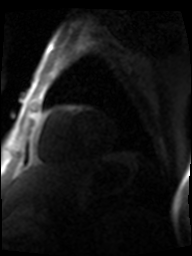

In [ ]:
cv2_imshow(a)

In [ ]:
a = cv2.imread('/content/drive/MyDrive/Tesis/images/myoperfdata/Study7_Rest/data010.png')

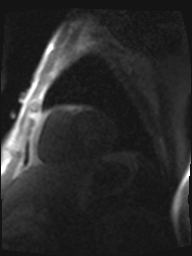

In [ ]:
cv2_imshow(a)

## Load images with Pytorch


We create a pytorch Dataset class for load all the images:

### Transformers

In [ ]:
class ToTensor(object):

    def __call__(self, sample):

        image = torch.from_numpy(sample)
        image = torch.unsqueeze(image, dim=0)
        return image

class ClipNorm(object):

    def __init__(self, lower=0, upper=99):
      self.lower = lower
      self.upper = upper
    

    def __call__(self, sample):

      lower_clip, upper_clip = np.percentile(sample, (self.lower, self.upper))
      clip_sample = sample.clip(min=lower_clip, max=upper_clip)
      clip_sample = self.rescale_intensity(clip_sample, (0, 255))

      return clip_sample

    def rescale_intensity(self, tensor, out_range):

      current_min = torch.min(tensor)
      current_max = torch.max(tensor)

      tensor = (tensor - current_min) / (current_max - current_min)
      tensor = out_range[0] + tensor * (out_range[1] - out_range[0])

      return tensor

class ZeroPad(object):

    def __init__(self, size=256):
      self.size = size

    def __call__(self, sample):
      if max(sample.size()[1], sample.size()[2]) > self.size:
        raise ValueError("Data can't be padded to a smaller shape.")
      
      h_pad = self.size - sample.size()[1]
      w_pad = self.size - sample.size()[2]

      padding_left = w_pad // 2
      padding_right = w_pad - padding_left

      padding_top = h_pad // 2
      padding_bottom = h_pad - padding_top
 
      padding = (padding_left, padding_right, padding_top, padding_bottom)

      paddet_data = torch.nn.functional.pad(sample, padding)

      return paddet_data  

### Dataset class

In [ ]:
class MyocardialPerfusionDataset(torch.utils.data.Dataset):

    def __init__(self, root, transform_img = torchvision.transforms.Compose([ToTensor(), ClipNorm(), ZeroPad()]), transform_mark = torchvision.transforms.Compose([ToTensor(), ZeroPad()])) -> None:
       
        self.root = root
        self.transform_mark = transform_mark
        self.transform_img = transform_img

        # create a dictionary for images.
        locations = list(sorted(os.listdir(os.path.join(self.root, 'dicom'))))
        img_dict = []
        for loc in locations:
            marks_ = nib.load(os.path.join(self.root, 'marks', '%s.nii.gz' % loc)).get_fdata()
            for index, img in enumerate(list(sorted(os.listdir(os.path.join(self.root, 'dicom', loc))))):
                if list(np.unique(marks_[:,:,index])) == [0., 1., 2.]:
                    dict_ = {'patient_id': loc, 'img_dir': os.path.join(self.root, 'dicom', loc, img), 'mark': marks_[:,:,index]}
                    img_dict.append(dict_)
        
        self.img_dict = img_dict


    def __getitem__(self, idx):
        path_img = self.img_dict[idx]['img_dir']
        dicom = pydicom.read_file(path_img).pixel_array.astype('int32')
        mark = self.img_dict[idx]['mark']
        #mark = nib.load(os.path.join(self.root, 'marks', '%s.nii.gz' % self.img_dict[idx]['patient_id'])).get_fdata()[:,:,self.img_dict[idx]['mark']]

        if self.transform_img:
            dicom = self.transform_img(dicom)

        if self.transform_mark:
            mark = self.transform_mark(mark)
        
        return dicom, mark

    def __len__(self):
        return len(self.img_dict)

## Create Dataloader

In [ ]:
def loader(dataset, batch_size, num_workers=2, shuffle=True):

    input_images = dataset

    input_loader = torch.utils.data.DataLoader(dataset=input_images,
                                                batch_size=batch_size,
                                                shuffle=shuffle,
                                                num_workers=num_workers)

    return input_loader

In [ ]:
path_train = '/content/drive/MyDrive/Tesis/images/P-UCH/'
path_val = '/content/drive/MyDrive/Tesis/images/Prueba'

In [ ]:
df = MyocardialPerfusionDataset(path_train)
df_2 = MyocardialPerfusionDataset(path_val)

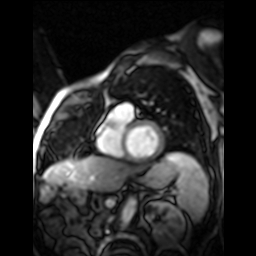

In [ ]:
cv2_imshow()

In [ ]:
img = np.asarray(df[215][0]).transpose((1,2,0))
img = np.squeeze(img)
mark = np.asarray(df[215][1]).transpose((1,2,0))
mark = np.squeeze(mark)

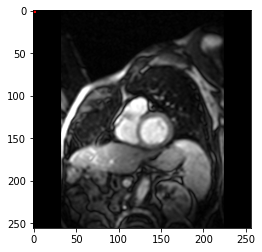

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.imshow(img, cmap='gray')
plt.scatter(mark[:, 0], mark[:, 1], s=10, marker='.', c='r')
plt.pause(0.001)
plt.figure()
plt.show()

In [ ]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

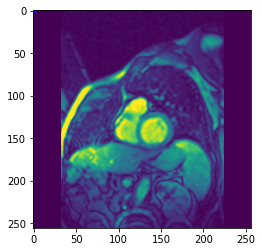

In [ ]:
plt.figure()
show_landmarks(img, mark)
plt.show()

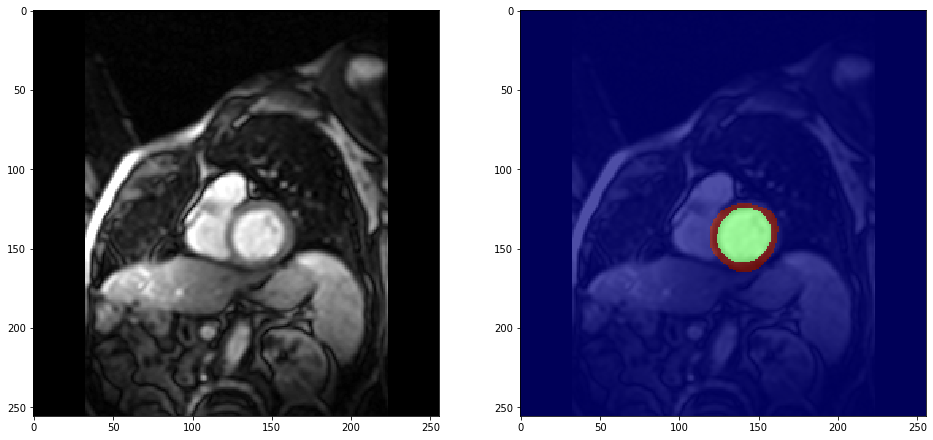

In [ ]:
plt.figure(figsize=(16, 12))
plt.subplot(1,2,1)
plt.imshow(img, 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(img, 'gray', interpolation='none')
plt.imshow(mark, 'jet', interpolation='none', alpha=0.7)
plt.show()

In [ ]:
training_loader = loader(MyocardialPerfusionDataset(path_train), 12)
val_loader = loader(MyocardialPerfusionDataset(path_val), 12)

## Unet

In [ ]:
import torch
from collections import OrderedDict

class UNet(torch.nn.Module):

    def __init__(self, input_channels=1, output_channels=1, init_features=32) -> None:
        super(UNet, self).__init__()

        features = init_features

        self.encoder_1 = UNet._block(input_channels, features, name='encoder_1')
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder_2 = UNet._block(features, features*2, name='encoder_2')
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder_3 = UNet._block(features*2, features*4, name='encoder_3')
        self.pool_3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder_4 = UNet._block(features*4, features*8, name='encoder_4')
        self.pool_4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features*8, features*16, name='bottleneck')

        self.upconv_4 = torch.nn.ConvTranspose2d(features*16, features*8, kernel_size=2, stride=2)
        self.decoder_4 = UNet._block((features*8)*2, features*8, name='decoder_4')
        self.upconv_3 = torch.nn.ConvTranspose2d(features*8, features*4, kernel_size=2, stride=2)
        self.decoder_3 = UNet._block((features*4)*2, features*4, name='decoder_3')
        self.upconv_2 = torch.nn.ConvTranspose2d(features*4, features*2, kernel_size=2, stride=2)
        self.decoder_2 = UNet._block((features*2)*2, features*2, name='decoder_2')
        self.upconv_1 = torch.nn.ConvTranspose2d(features*2, features, kernel_size=2, stride=2)
        self.decoder_1 = UNet._block(features*2, features, name='decoder_1')
        self.conv = torch.nn.Conv2d(features, output_channels, kernel_size=1)

    def forward(self, sample):
        encoder_1 = self.encoder_1(sample)
        encoder_2 = self.encoder_2(self.pool_1(encoder_1))
        encoder_3 = self.encoder_3(self.pool_2(encoder_2))
        encoder_4 = self.encoder_4(self.pool_3(encoder_3))

        bottleneck = self.bottleneck(self.pool_4(encoder_4))

        decoder_4 = self.upconv_4(bottleneck)
        decoder_4 = torch.cat((decoder_4, encoder_4), dim=1)
        decoder_4 = self.decoder_4(decoder_4)
        decoder_3 = self.upconv_3(decoder_4)
        decoder_3 = torch.cat((decoder_3, encoder_3), dim=1)
        decoder_3 = self.decoder_3(decoder_3)
        decoder_2 = self.upconv_2(decoder_3)
        decoder_2 = torch.cat((decoder_2, encoder_2), dim=1)
        decoder_2 = self.decoder_2(decoder_2)
        decoder_1 = self.upconv_1(decoder_2)
        decoder_1 = torch.cat((decoder_1, encoder_1), dim=1)
        decoder_1 = self.decoder_1(decoder_1)

        return torch.sigmoid(self.conv(decoder_1))




    @staticmethod
    def _block(in_channels, features, name):
        return torch.nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        torch.nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", torch.nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", torch.nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        torch.nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", torch.nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", torch.nn.ReLU(inplace=True)),
                ]
            )
        )

In [ ]:
class DiceLoss(torch.nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

## Train

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [ ]:
def train_one_epoch(epoch_index, tb_writer):

    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
model = UNet()
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = DiceLoss()

In [ ]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/myocardial_{}'.format(timestamp))

epoch_number = 0
EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(val_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
0
1
2
3


KeyboardInterrupt: ignored